## Wave polarization using SCM data

This notebook demonstrates usage of the wave polarization routines using MMS SCM data, and is largely based on the mms_wavpol_crib crib sheet in IDL.

This version stores these outputs as tplot variables with the specified prefix; these are follows:
- Wave power: On a linear scale (units of nT^2/Hz if input Bx, By, Bz are in nT)

- Degree of Polarisation: This is similar to a measure of coherency between the input signals, however unlike coherency it is invariant under coordinate transformation and can detect pure state waves which may exist in one channel only.100% indicates a pure state wave. Less than 70% indicates noise. For more  information see J. C. Samson and J. V. Olson 'Some comments on the description of the polarization states of waves' Geophys. J. R. Astr. Soc. (1980) v61 115-130

- Wavenormal Angle: The angle between the direction of minimum variance calculated from the complex off diagonal elements of the spectral matrix and the Z direction of the input ac field data. For magnetic field data in field aligned coordinates this is the wavenormal angle assuming a plane wave.

- Ellipticity: The ratio (minor axis)/(major axis) of the ellipse transcribed by the field variations of the components transverse to the Z direction. The sign  indicates the direction of rotation of the field vector in the plane. Negative signs refer to left-handed rotation about the Z direction. In the field aligned coordinate system these signs refer to plasma waves of left and right handed polarisation.

- Helicity: Similar to Ellipticity except defined in terms of the direction of minimum variance instead of Z. Strictly the Helicity is defined in terms of the wavenormal direction or k. However since from single point observations the sense of k cannot be determined,  helicity here is simply the ratio of the minor to major axis transverse to the minimum variance direction without sign.

This command sets up the PySPEDAS environment when running in Google Colab.  You can skip it or comment it out if you're running this notebook in an environment that already has PySPEDAS installed.


In [1]:
!pip install pyspedas


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pyspedas
from pyspedas import tplot, get_data, store_data, options, ylim, zlim

import numpy as np # needed for np.pi

Load the SCM data

In [3]:
trange = ['2015-10-16/13:05:40', '2015-10-16/13:07:25'] # Burch et al., Science event

sc = '4'
scm_data_rate = 'brst'

# Select mode ('scsrvy' for survey data rate (both slow and fast have 32 S/s), 
#                'scb' (8192 S/s) or 'schb' (16384 S/s) for burst data rate)
scm_datatype = 'scb'

pyspedas.projects.mms.scm(probe=sc, datatype=scm_datatype, level='l2', trange=trange, data_rate=scm_data_rate)

mms_scm_name = 'mms'+sc+'_scm_acb_gse_'+scm_datatype+'_'+scm_data_rate+'_l2'


13-Feb-25 15:24:35: Loading pydata/mms4/scm/brst/l2/scb/2015/10/16/mms4_scm_brst_l2_scb_20151016130524_v2.2.0.cdf


Get FGM data in order to define Field-Aligned Coordinate (FAC) system

In [4]:
fgm_data_rate = 'srvy'

pyspedas.projects.mms.fgm(probe=sc, trange=trange, data_rate=fgm_data_rate)

mms_fgm_name = 'mms'+sc+'_fgm_b_gse_'+fgm_data_rate+'_l2_bvec'
all_b = 'mms'+sc+'_fgm_b_gse_'+fgm_data_rate+'_l2' # variable containing vector + magnitude, for the figures

13-Feb-25 15:24:36: Loading pydata/mms4/fgm/srvy/l2/2015/10/mms4_fgm_srvy_l2_20151016_v4.18.0.cdf


Use fac_matrix_make to create the FAC transformation matrices. Note that the FG<M data may contain NaN values, so we use tdeflag to remove any data points and times with NaN values, and use the cleaned data to make the FAC matrices.

In [5]:
from pyspedas import fac_matrix_make, tdeflag
mms_fgm_name = 'mms'+sc+'_fgm_b_gse_'+fgm_data_rate+'_l2_bvec'

tdeflag(mms_fgm_name, method='remove_nan')

fac_matrix_make(mms_fgm_name+'-deflag', other_dim='xgse', newname=mms_fgm_name+'_fac_mat')

13-Feb-25 15:24:39: tdeflag was applied to: mms4_fgm_b_gse_srvy_l2_bvec-deflag


'mms4_fgm_b_gse_srvy_l2_bvec_fac_mat'

Use tvector_rotate() to apply the FAC transformation matrices to the SCM data

In [6]:
from pyspedas import tvector_rotate
tvector_rotate('mms4_fgm_b_gse_srvy_l2_bvec_fac_mat',mms_scm_name, newname=mms_scm_name + '_fac')

['mms4_scm_acb_gse_scb_brst_l2_fac']

Calculate polarization

In [7]:
from pyspedas import twavpol

# number of points for FFT
nopfft_input = 8192 # 1024

# number of points for shifting between 2 FFT
steplength_input = nopfft_input/2

# number of bins for frequency averaging
bin_freq_input = 3

twavpol(mms_scm_name+'_fac', nopfft=nopfft_input, steplength=steplength_input,bin_freq=bin_freq_input)

13-Feb-25 15:24:42: wavpol Warning: file sampling frequency changes from 8208.031311154598Hz to 8192.0Hz
13-Feb-25 15:24:42: n_batches: 1
13-Feb-25 15:24:42: Total number of steps:210
13-Feb-25 15:24:42: Total number of possible FFT in the batch no 0 is:209.0
13-Feb-25 15:24:42: /Users/jwl/PycharmProjects/mms-examples/venv/lib/python3.9/site-packages/pyspedas/analysis/twavpol.py:142: ComplexWarning: Casting complex values to real discards the imaginary part
  alphax[KK, :] = np.sqrt(ematspec[KK, :, 0, 0])

13-Feb-25 15:24:42: /Users/jwl/PycharmProjects/mms-examples/venv/lib/python3.9/site-packages/pyspedas/analysis/twavpol.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  alphacos2x[KK, :] = (np.real(ematspec[KK, :, 0, 1]) /

13-Feb-25 15:24:42: /Users/jwl/PycharmProjects/mms-examples/venv/lib/python3.9/site-packages/pyspedas/analysis/twavpol.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  alphasin2x[KK, :] = (-np.

1

List the available variables

In [8]:
from pyspedas import tplot_names
tplot_names()

0 : mms4_scm_acb_gse_scb_brst_l2
1 : Epoch
2 : mms4_fgm_b_gse_srvy_l2
3 : mms4_fgm_b_gsm_srvy_l2
4 : mms4_fgm_b_dmpa_srvy_l2
5 : mms4_fgm_b_bcs_srvy_l2
6 : mms4_fgm_flag_srvy_l2
7 : Epoch_state
8 : mms4_fgm_hirange_srvy_l2
9 : mms4_fgm_bdeltahalf_srvy_l2
10 : mms4_fgm_stemp_srvy_l2
11 : mms4_fgm_etemp_srvy_l2
12 : mms4_fgm_mode_srvy_l2
13 : mms4_fgm_b_dmpa_srvy_l2_bvec
14 : mms4_fgm_b_dmpa_srvy_l2_btot
15 : mms4_fgm_b_gse_srvy_l2_bvec
16 : mms4_fgm_b_gse_srvy_l2_btot
17 : mms4_fgm_b_gsm_srvy_l2_bvec
18 : mms4_fgm_b_gsm_srvy_l2_btot
19 : mms4_fgm_b_bcs_srvy_l2_bvec
20 : mms4_fgm_b_bcs_srvy_l2_btot
21 : mms4_fgm_b_gse_srvy_l2_bvec-deflag
22 : mms4_fgm_b_gse_srvy_l2_bvec_fac_mat
23 : mms4_scm_acb_gse_scb_brst_l2_fac
24 : mms4_scm_acb_gse_scb_brst_l2_fac_powspec
25 : mms4_scm_acb_gse_scb_brst_l2_fac_degpol
26 : mms4_scm_acb_gse_scb_brst_l2_fac_waveangle
27 : mms4_scm_acb_gse_scb_brst_l2_fac_elliptict
28 : mms4_scm_acb_gse_scb_brst_l2_fac_helict
29 : mms4_scm_acb_gse_scb_brst_l2_fac_pspec3_

['mms4_scm_acb_gse_scb_brst_l2',
 'Epoch',
 'mms4_fgm_b_gse_srvy_l2',
 'mms4_fgm_b_gsm_srvy_l2',
 'mms4_fgm_b_dmpa_srvy_l2',
 'mms4_fgm_b_bcs_srvy_l2',
 'mms4_fgm_flag_srvy_l2',
 'Epoch_state',
 'mms4_fgm_hirange_srvy_l2',
 'mms4_fgm_bdeltahalf_srvy_l2',
 'mms4_fgm_stemp_srvy_l2',
 'mms4_fgm_etemp_srvy_l2',
 'mms4_fgm_mode_srvy_l2',
 'mms4_fgm_b_dmpa_srvy_l2_bvec',
 'mms4_fgm_b_dmpa_srvy_l2_btot',
 'mms4_fgm_b_gse_srvy_l2_bvec',
 'mms4_fgm_b_gse_srvy_l2_btot',
 'mms4_fgm_b_gsm_srvy_l2_bvec',
 'mms4_fgm_b_gsm_srvy_l2_btot',
 'mms4_fgm_b_bcs_srvy_l2_bvec',
 'mms4_fgm_b_bcs_srvy_l2_btot',
 'mms4_fgm_b_gse_srvy_l2_bvec-deflag',
 'mms4_fgm_b_gse_srvy_l2_bvec_fac_mat',
 'mms4_scm_acb_gse_scb_brst_l2_fac',
 'mms4_scm_acb_gse_scb_brst_l2_fac_powspec',
 'mms4_scm_acb_gse_scb_brst_l2_fac_degpol',
 'mms4_scm_acb_gse_scb_brst_l2_fac_waveangle',
 'mms4_scm_acb_gse_scb_brst_l2_fac_elliptict',
 'mms4_scm_acb_gse_scb_brst_l2_fac_helict',
 'mms4_scm_acb_gse_scb_brst_l2_fac_pspec3_x',
 'mms4_scm_acb_gse

change of units from radians to degrees for wave angle variable

In [9]:
time_wa, val_wa, val_freq = get_data(mms_scm_name + '_fac_waveangle')

val_wa = val_wa*180./np.pi

store_data(mms_scm_name+'_fac_waveangle', data={'x':time_wa, 'y':val_wa, 'v':val_freq})

True

only plot polarization results if the degree of polarization is larger than 0.7

In [10]:
deg_pol_c = 0.7

time, val, val_freq = get_data(mms_scm_name+'_fac_degpol')
index_deg_pol = val < deg_pol_c
val[index_deg_pol] = np.nan
store_data(mms_scm_name+'_fac_degpol',data={'x':time, 'y':val, 'v':val_freq})

time, val, val_freq = get_data(mms_scm_name+'_fac_powspec')
val[index_deg_pol] = np.nan
store_data(mms_scm_name+'_fac_powspec',data={'x':time, 'y':val, 'v':val_freq})

time,val,val_freq = get_data(mms_scm_name+'_fac_waveangle')
val[index_deg_pol] = np.nan
store_data(mms_scm_name+'_fac_waveangle',data={'x':time, 'y':val, 'v':val_freq})

time, val, val_freq = get_data(mms_scm_name+'_fac_elliptict')
val[index_deg_pol] = np.nan
store_data(mms_scm_name+'_fac_elliptict',data={'x':time, 'y':val, 'v':val_freq})

time,val,val_freq = get_data(mms_scm_name+'_fac_helict')
val[index_deg_pol] = np.nan
store_data(mms_scm_name+'_fac_helict',data={'x':time, 'y':val, 'v':val_freq})

True

Plot the calculated data

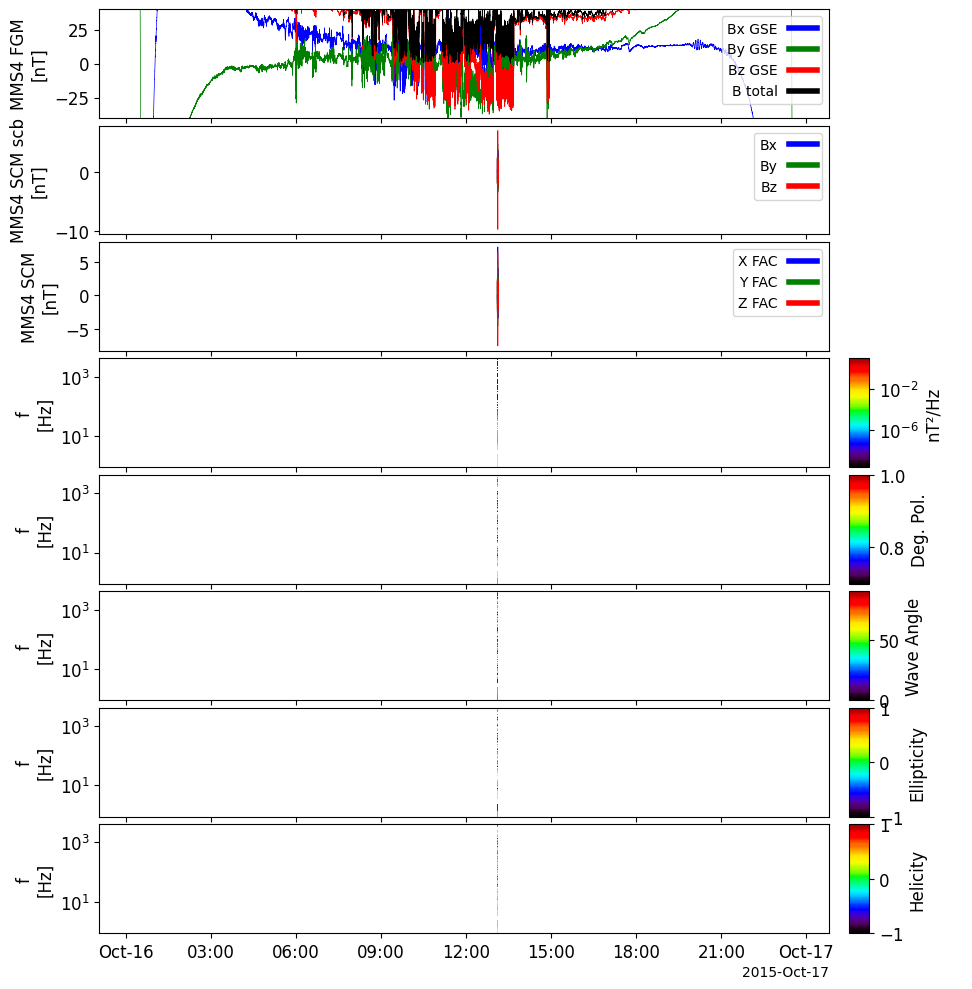

In [11]:
if scm_datatype == 'scb': samp_freq = 8192.
if scm_datatype == 'scsrvy': samp_freq = 32.

freq_min = np.floor(samp_freq/nopfft_input)
if scm_datatype == 'scb': freq_max = 4096.
if scm_datatype == 'scsrvy': freq_max = 16.

nlog_f = 1

options(all_b, 'yrange', [-40, 40])

options(mms_scm_name+'_fac', 'Color', ['b', 'g', 'r'])
options(mms_scm_name+'_fac', 'legend_names', ['X FAC', 'Y FAC', 'Z FAC'])
options(mms_scm_name+'_fac', 'ytitle', 'MMS'+sc+' SCM')

ylim(mms_scm_name+'_fac_powspec', freq_min, freq_max)
ylim(mms_scm_name+'_fac_degpol', freq_min, freq_max)
ylim(mms_scm_name+'_fac_waveangle', freq_min, freq_max)
ylim(mms_scm_name+'_fac_elliptict', freq_min, freq_max)
ylim(mms_scm_name+'_fac_helict', freq_min, freq_max)

options(mms_scm_name+'_fac_powspec', 'spec', True)
options(mms_scm_name+'_fac_degpol', 'spec', True)
options(mms_scm_name+'_fac_waveangle', 'spec', True)
options(mms_scm_name+'_fac_elliptict', 'spec', True)
options(mms_scm_name+'_fac_helict', 'spec', True)

options(mms_scm_name+'_fac_powspec', 'ztitle', 'nT²/Hz')
options(mms_scm_name+'_fac_degpol', 'ztitle', 'Deg. Pol.')
options(mms_scm_name+'_fac_waveangle', 'ztitle', 'Wave Angle')
options(mms_scm_name+'_fac_elliptict', 'ztitle', 'Ellipticity')
options(mms_scm_name+'_fac_helict', 'ztitle', 'Helicity')

options(mms_scm_name+'_fac_powspec', 'ytitle', 'f')
options(mms_scm_name+'_fac_powspec', 'ysubtitle', '[Hz]')
options(mms_scm_name+'_fac_degpol', 'ytitle', 'f')
options(mms_scm_name+'_fac_degpol', 'ysubtitle', '[Hz]')
options(mms_scm_name+'_fac_waveangle', 'ytitle', 'f')
options(mms_scm_name+'_fac_waveangle', 'ysubtitle', '[Hz]')
options(mms_scm_name+'_fac_elliptict', 'ytitle', 'f')
options(mms_scm_name+'_fac_elliptict', 'ysubtitle', '[Hz]')
options(mms_scm_name+'_fac_helict', 'ytitle', 'f')
options(mms_scm_name+'_fac_helict', 'ysubtitle', '[Hz]')

options(mms_scm_name+'_fac_powspec', 'zlog', True)

options(mms_scm_name+'_fac_powspec', 'ylog', True)
options(mms_scm_name+'_fac_degpol', 'ylog', True)
options(mms_scm_name+'_fac_waveangle', 'ylog', True)
options(mms_scm_name+'_fac_elliptict', 'ylog', True)
options(mms_scm_name+'_fac_helict', 'ylog', True)

zlim(mms_scm_name+'_fac_degpol', 0.7, 1.)
zlim(mms_scm_name+'_fac_waveangle', 0., 90.)
zlim(mms_scm_name+'_fac_elliptict', -1.0, 1.0)
zlim(mms_scm_name+'_fac_helict', -1.0, 1.0)

tplot([all_b ,
       mms_scm_name,
       mms_scm_name+'_fac',
       'mms4_scm_acb_gse_scb_brst_l2_fac_powspec',
       'mms4_scm_acb_gse_scb_brst_l2_fac_degpol',
       'mms4_scm_acb_gse_scb_brst_l2_fac_waveangle',
       'mms4_scm_acb_gse_scb_brst_l2_fac_elliptict',
       'mms4_scm_acb_gse_scb_brst_l2_fac_helict'], xsize=10, ysize=12)

The above plot covers the time range of the FGM data, but the wave polarization variables were computed from a much shorter time interval when SCM data was available.   We can use the SCM time range and the timespan() function to zoom in on the time range of interest so the spectrograms are more legible.

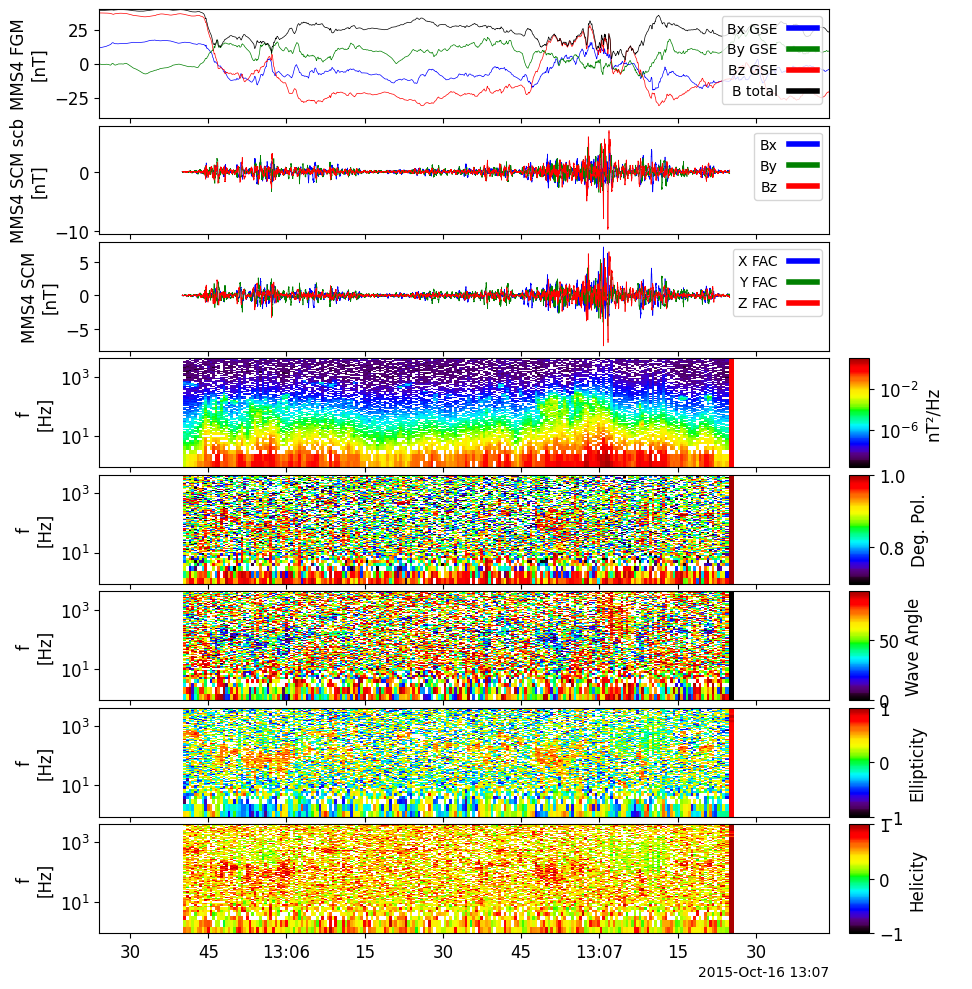

In [12]:
from pyspedas import timespan

# We could get the SCM start/end times by extracting the time array and taking the
# first/last values, but the time range is already stored in the tplot metadata, so
# we'll just pull it from there.
md=get_data(mms_scm_name + '_fac', metadata=True)
scm_trange = md['plot_options']['trange']

# We now have the start/end times in scm_trange, but the timespan() routine
# expects a start time and duration

start_time = scm_trange[0]
duration = scm_trange[1]-start_time

# Set the time range to be used for this and future plots.

timespan(start_time, duration, 'seconds')

# Plot the data zoomed in on the SCM time range
tplot([all_b ,
       mms_scm_name,
       mms_scm_name+'_fac',
       'mms4_scm_acb_gse_scb_brst_l2_fac_powspec',
       'mms4_scm_acb_gse_scb_brst_l2_fac_degpol',
       'mms4_scm_acb_gse_scb_brst_l2_fac_waveangle',
       'mms4_scm_acb_gse_scb_brst_l2_fac_elliptict',
       'mms4_scm_acb_gse_scb_brst_l2_fac_helict'], xsize=10, ysize=12)